# Image captioning with visual attention 

## Learning Objectives
1. Learn how to create an image captioning model
2. Learn how to train and predict a text generation model.

Given an image like the example below, your goal is to generate a caption such as *"some people are playing baseball."*.

![Baseball](https://user-images.githubusercontent.com/6895245/173933422-d48f522e-b0a9-4ccd-aef8-480de25a6fe3.png)


The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. The training dataset is the COCO large-scale object detection, segmentation, and captioning dataset.


## Preparation

In [1]:
import time

import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")
print(f"Found GPU at: {device_name}")

2.8.2
Found GPU at: /device:GPU:0


2022-06-15 21:18:15.445487: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-15 21:18:16.105032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 21:18:16.117097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-15 21:18:16.117811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [2]:
!rm -rf /tmp/*tfds*

## Read and prepare dataset

We will use the TensorFlow datasets capability to read the [COCO captions](https://www.tensorflow.org/datasets/catalog/coco_captions) dataset.
This version contains images, bounding boxes, labels, and captions from COCO 2014, split into the subsets defined by Karpathy and Li (2015) and takes
care of some data quality issues with the original dataset (for example, some
of the images in the original dataset did not have captions)


In [3]:
# Change these to control the accuracy/speed
VOCAB_SIZE = 5000  # use fewer words to speed up convergence
UNITS = 512  # size of dense layer in Attention; larger more fine-grained
EMBED_DIM = 256  # embedding dimension for both images and words

# This is what EfficientNetV2-B0 was trained with, so don't change unless you
# use a different pre-trained model. EfficientNetV2-B0 takes (224, 224, 3) as
# input and provides (7, 7, 1024) as output.
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
FEATURES_SHAPE = (7, 7, 1024)

### Filter and Preprocess
Here we filter and preprocess the dataset. The function below:
- resize image to (`IMG_HEIGHT`, `IMG_WIDTH`) shape
- rescale pixel values to [0,1]
- return image(`image_tensor`), id(`image_id`) and captions(`captions`) dictionary.

**Note**: This dataset is too large to store in an ephemeral location. Therefore, It is stored in a public GCS bucket. 
If you access it from a Notebook outside the US, it will be (a) slow and (b) subject to a network charge.


In [4]:
GCS_DIR = "gs://asl-public/data/tensorflow_datasets/"


def filter_for_crowds(example):
    return (
        tf.math.count_nonzero(example["objects"]["is_crowd"]) > 0
    )  # extract images with multiple objects


def get_image_label(example):
    captions = example["captions"]["text"]  # all the captions
    img_id = example["image/id"]
    img = example["image"]
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255
    return {"image_tensor": img, "image_id": img_id, "captions": captions}


trainds = tfds.load(
    "coco_captions", split="train", shuffle_files=True, data_dir=GCS_DIR
)

# reduce number of images in one of these ways
trainds = trainds.filter(filter_for_crowds)  # 6385 records
# trainds = trainds.take(10000)

trainds = trainds.map(get_image_label)

2022-06-17 09:45:41.775119: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 09:45:41.775955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 09:45:41.776649: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 09:45:41.777816: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 09:45:41.778514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

### Visualize 
Let's take a look at images and sample captions in the dataset.

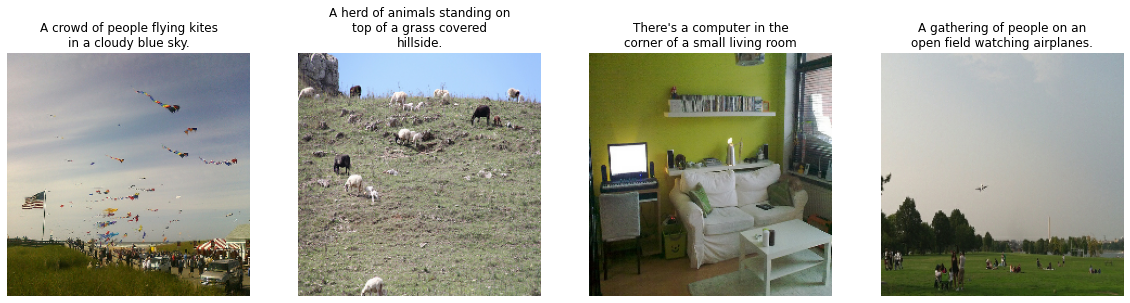

In [5]:
from textwrap import wrap

f, ax = plt.subplots(1, 4, figsize=(20, 5))
for idx, data in enumerate(trainds.take(4)):
    ax[idx].imshow(data["image_tensor"].numpy())
    # ax[idx].set_xlabel('image_id={}'.format(data['image_id'].numpy()))
    caption = "\n".join(wrap(data["captions"].numpy()[0].decode("utf-8"), 30))
    ax[idx].set_title(caption)
    ax[idx].axis("off")

## Text Preprocessing

We add special tokens to represent the starts (`<start>`) and the ends (`<end>`) of sentences.

Then create a full list of the captions for further preprocessing.

In [6]:
# Stop words for stability
STOPWORDS = {
    "ourselves",
    "hers",
    "between",
    "yourself",
    "but",
    "again",
    "there",
    "about",
    "once",
    "during",
    "out",
    "very",
    "having",
    "with",
    "they",
    "own",
    "an",
    "be",
    "some",
    "for",
    "do",
    "its",
    "yours",
    "such",
    "into",
    "of",
    "most",
    "itself",
    "other",
    "off",
    "is",
    "s",
    "am",
    "or",
    "who",
    "as",
    "from",
    "him",
    "each",
    "the",
    "themselves",
    "until",
    "below",
    "are",
    "we",
    "these",
    "your",
    "his",
    "through",
    "don",
    "nor",
    "me",
    "were",
    "her",
    "more",
    "himself",
    "this",
    "down",
    "should",
    "our",
    "their",
    "while",
    "above",
    "both",
    "up",
    "to",
    "ours",
    "had",
    "she",
    "all",
    "no",
    "when",
    "at",
    "any",
    "before",
    "them",
    "same",
    "and",
    "been",
    "have",
    "in",
    "will",
    "on",
    "does",
    "yourselves",
    "then",
    "that",
    "because",
    "what",
    "over",
    "why",
    "so",
    "can",
    "did",
    "not",
    "now",
    "under",
    "he",
    "you",
    "herself",
    "has",
    "just",
    "where",
    "too",
    "only",
    "myself",
    "which",
    "those",
    "i",
    "after",
    "few",
    "whom",
    "t",
    "being",
    "if",
    "theirs",
    "my",
    "against",
    "a",
    "by",
    "doing",
    "it",
    "how",
    "further",
    "was",
    "here",
    "than",
}
MAX_CAPTION_LEN = 1


def preprocess_caption(c):
    global MAX_CAPTION_LEN
    caption = "<start> {} <end>".format(c.decode("utf-8"))
    words = [word for word in caption.lower().split() if word not in STOPWORDS]
    MAX_CAPTION_LEN = max(MAX_CAPTION_LEN, len(words))
    return " ".join(words)


train_captions = []
for data in trainds:
    str_captions = [preprocess_caption(c) for c in data["captions"].numpy()]
    train_captions.extend(str_captions)

## Preprocess and tokenize the captions

You will transform the text captions into integer sequences using the [TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer, with the following steps:

* Use [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt) to iterate over all captions, split the captions into words, and compute a vocabulary of the top `VOOCAB_SIZE` (like 5000) words (to save memory).
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length `MAX_CAPTION_LEN` (like 50).
* Create word-to-index and index-to-word mappings to display results.

In [7]:
# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
    return tf.strings.regex_replace(
        inputs, r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", ""
    )


# Choose the most frequent words from the vocabulary & remove punctuation etc.
tokenizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_CAPTION_LEN,
)
tokenizer.adapt(train_captions)


Let's try to tokenize a sample text 

In [8]:
tokenizer(["<start> This is a sentence <end>"])

<tf.Tensor: shape=(1, 33), dtype=int64, numpy=
array([[2, 1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

In [9]:
print(train_captions[:5])

['<start> crowd people flying kites cloudy blue sky. <end>', '<start> large number kites flying sky <end>', '<start> sky full kites flown crowd. <end>', '<start> large group people flying series kites. <end>', '<start> people field kites flying air. <end>']


In [10]:
print(tokenizer(train_captions[:5]))

tf.Tensor(
[[  2  20   4  17  32 342  63 184   3   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   9 126  32  17 161   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2 161  49  32 384 193   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   9   5   4  17 863 136   3   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   4  28  32  17 254   3   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(5, 33), dtype=int64)


And you can convert ids to original text.

In [11]:
for wordid in tokenizer([train_captions[0]])[0]:
    print(tokenizer.get_vocabulary()[wordid], end=" ")

<start> crowd people flying kites cloudy blue sky. <end>                         

Also, we can create Word <-> Index converters using `StringLookup` layer.

In [12]:
# Lookup table: Word -> Index
word_to_index = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary()
)

# Lookup table: Index -> Word
index_to_word = tf.keras.layers.StringLookup(
    mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True
)

### Create a tf.data dataset for training
Now Let's apply the adapted Tokenization to all the examples and create tf.data Dataset for training.

In [13]:
BUFFER_SIZE = 1000


def create_batched_ds(trainds, batchsize):
    # generator that does tokenization, padding on the caption strings
    # and yields img, caption
    def generate_image_captions():
        for data in trainds:
            captions = data["captions"]
            img_tensor = data["image_tensor"]
            str_captions = [
                preprocess_caption(c) for c in data["captions"].numpy()
            ]
            padded = tokenizer(str_captions)
            for caption in padded:
                yield img_tensor, caption  # repeat image

    return (
        tf.data.Dataset.from_generator(
            generate_image_captions, (tf.float32, tf.int32)
        )
        .shuffle(BUFFER_SIZE)
        .batch(batchsize)
    )


for img, caption in create_batched_ds(trainds, 64).take(2):
    print(img.shape, caption.shape)
    print(caption[0])

(64, 224, 224, 3) (64, 33)
tf.Tensor(
[   2   20    4   26 2145  183    3    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(33,), dtype=int32)
(64, 224, 224, 3) (64, 33)
tf.Tensor(
[   2 2253 4004   86  761    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(33,), dtype=int32)


## Model

It consists of an image encoder, followed by a caption decoder.

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of EfficientNet V2 B0 giving us a vector of length 1280.
* You squash that to a length of 256 with a Dense Layer.
* The RNN (here GRU) attends over the image to predict the next word.

### Image Encoder
The image encoder model is very simple. It extracts features through a pretrained model and passes them to a fully connected layer.

In [14]:
class ImageEncoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super().__init__()
        efficientnet_v2 = (
            tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
                include_top=False, weights="imagenet"
            )
        )
        self.model = tf.keras.Model(
            efficientnet_v2.input, efficientnet_v2.layers[-1].output
        )
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.model(x)
        x = tf.reshape(x, (x.shape[0], -1, x.shape[3]))
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [15]:
encoder = ImageEncoder(EMBED_DIM)

### Decoder Part
The caption decoder incorporates an attention mechanism that focuses on different parts of the input image.


#### The attention head

The decoder uses attention to selectively focus on parts of the input sequence.
The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. This attention layer is similar to a `layers.GlobalAveragePoling1D` but the attention layer performs a _weighted_ average.

Let's look at how this works:

<img src="https://user-images.githubusercontent.com/6895245/173408554-d4b6387b-248b-421e-8911-550d0561d001.png" alt="attention equation 1" width="800">

<img src="https://user-images.githubusercontent.com/6895245/173408648-38c6b582-a68b-4697-982a-1d885b83dd0b.png" alt="attention equation 2" width="800">

Where:

* $s$ is the encoder index.
* $t$ is the decoder index.
* $\alpha_{ts}$ is the attention weights.
* $h_s$ is the sequence of encoder outputs being attended to (the attention "key" and "value" in transformer terminology).
* $h_t$ is the the decoder state attending to the sequence (the attention "query" in transformer terminology).
* $c_t$ is the resulting context vector.
* $a_t$ is the final output combining the "context" and "query".

The equations:

1. Calculates the attention weights, $\alpha_{ts}$, as a softmax across the encoder's output sequence.
2. Calculates the context vector as the weighted sum of the encoder outputs.

Last is the $score$ function. Its job is to calculate a scalar logit-score for each key-query pair. There are two common approaches:

<img src="https://user-images.githubusercontent.com/6895245/173408773-3781cacc-de00-49c6-9909-f6cd65a0501b.png" alt="attention equation 4" width="800">

This notebook implement [Bahdanau's additive attention](https://arxiv.org/pdf/1409.0473.pdf), but TensorFlow includes implementations of both as `layers.Attention` and
`layers.AdditiveAttention`.

In [16]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 7*7, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        query = self.W1(features)

        value = self.W2(hidden_with_time_axis)
        # attention_hidden_layer shape == (batch_size, 7*7, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # score shape == (batch_size, 7*7, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 7*7, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

#### Caption Decoder

The decoder's job is to generate predictions for the next output token.

1. The decoder receives the complete encoder output.
1. Bahdanau-style attention attends over the encoder's output feature by using GRU hidden state as a query.
1. It uses a GRU to keep track of what it has generated.
1. It generates logit predictions for the next token based on the GRU output.


In [17]:
class CaptionDecoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super().__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embedding_dim, input_length=MAX_CAPTION_LEN
        )

        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [18]:
decoder = CaptionDecoder(EMBED_DIM, UNITS, VOCAB_SIZE)

### Compile
The loss function is a simple cross-entropy, but we need to remove padding (`0`) when calculating it.

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    # returns 1 for words index and 0 for padding (e.g. [1,1,1,1,1,0,0,0,0,...,0])
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # Remove padding

    return tf.reduce_mean(loss_)

## Training loop

* You extract the features from images through the encoder.
* The encoder output, hidden state(initialized to 0), and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder's hidden state.
* The decoder's hidden state is then passed back into the model, and the predictions will be used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder. (Teacher forcing is the technique where the target word is passed as the next input to the decoder.)
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [20]:
loss_plot = []

# Called for each step of training
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # initialize the batch of predictions with [[3],[3], ...] i.e. with start tokens
    dec_input = tf.expand_dims([word_to_index("<start>")] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])

    trainable_variables = (
        encoder.trainable_variables + decoder.trainable_variables
    )

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [21]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(
    encoder=encoder, decoder=decoder, optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [22]:
EPOCHS = 5  # train longer for greater accuracy
BATCH_SIZE = (
    64  # larger batch sizes lead to smoother convergence, but need more memory
)

EARLY_STOP_THRESH = 0.0001  # stop once loss improvement is less than this value

batched_ds = create_batched_ds(trainds, BATCH_SIZE)

prev_loss = 999
for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    num_steps = 0

    for batch, (img_tensor, target) in enumerate(batched_ds):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        num_steps += 1

        if batch % 100 == 0:
            print(
                "Epoch {} Batch {} Loss {:.4f}".format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
                )
            )

    current_loss = total_loss / num_steps

    # storing the epoch end loss value to plot later
    loss_plot.append(current_loss)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print(
        "Epoch {} Loss {:.6f} Time taken {:.1f} sec".format(
            epoch + 1, current_loss, time.time() - start
        )
    )

    # stop once it has converged
    improvement = prev_loss - current_loss
    if improvement < EARLY_STOP_THRESH:
        print(
            "Stopping because improvement={} < {}".format(
                improvement, EARLY_STOP_THRESH
            )
        )
        break
    prev_loss = current_loss

2022-06-17 09:50:03.957296: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


Epoch 1 Batch 0 Loss 1.9427
Epoch 1 Batch 100 Loss 1.1921
Epoch 1 Batch 200 Loss 1.0749
Epoch 1 Batch 300 Loss 0.9470
Epoch 1 Batch 400 Loss 0.8892
Epoch 1 Loss 1.048614 Time taken 486.7 sec
Epoch 2 Batch 0 Loss 0.9273
Epoch 2 Batch 100 Loss 0.8210
Epoch 2 Batch 200 Loss 0.7438
Epoch 2 Batch 300 Loss 0.7717
Epoch 2 Batch 400 Loss 0.8321
Epoch 2 Loss 0.828222 Time taken 333.6 sec
Epoch 3 Batch 0 Loss 0.8308
Epoch 3 Batch 100 Loss 0.7844
Epoch 3 Batch 200 Loss 0.8085
Epoch 4 Batch 100 Loss 0.7516
Epoch 4 Batch 200 Loss 0.7759
Epoch 4 Batch 300 Loss 0.7244
Epoch 4 Batch 400 Loss 0.7033
Epoch 4 Loss 0.736256 Time taken 335.4 sec
Epoch 5 Batch 0 Loss 0.6640
Epoch 5 Batch 100 Loss 0.7343
Epoch 5 Batch 200 Loss 0.7435
Epoch 5 Batch 300 Loss 0.7445
Epoch 5 Batch 400 Loss 0.6892
Epoch 5 Loss 0.711859 Time taken 336.2 sec


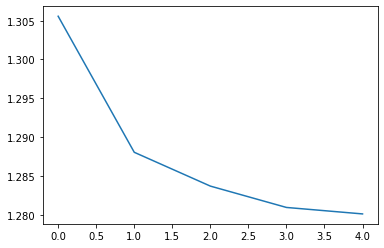

In [23]:
plt.plot(loss_plot);

## Caption!

* The `predict_caption` function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.
* Optionally, during the prediction, you can control the caption by adding masks.

In [24]:
MINIMUM_SENTENCE_LENGTH = 10

## Probabilistic prediction using the trained model
def predict_caption(filename):
    attention_plot = np.zeros(
        (MAX_CAPTION_LEN, FEATURES_SHAPE[0] * FEATURES_SHAPE[1])
    )
    hidden = decoder.reset_state(batch_size=1)
    img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = img / 255

    features = encoder(tf.expand_dims(img, axis=0))
    dec_input = tf.expand_dims([word_to_index("<start>")], 1)
    result = []
    previous_word_ids = []
    for i in range(MAX_CAPTION_LEN):
        predictions, hidden, attention_weights = decoder(
            dec_input, features, hidden
        )
        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        # mask out <start> <end> and unkonw words, since we don't want them so far
        masked_predictions = predictions[0]
        mask = [1.0] * (masked_predictions.shape[0])
        mask[word_to_index("<start>").numpy()] = 0
        mask[word_to_index("<end>").numpy()] = 0
        mask[word_to_index("___UNKNOWN___").numpy()] = 0

        # <end> is okay after some time
        if i > MINIMUM_SENTENCE_LENGTH - 1:
            mask[word_to_index("<end>").numpy()] = 1
        # avoid repeating words
        for p in previous_word_ids:
            mask[p] = 0
        mask = tf.convert_to_tensor(mask)
        masked_predictions *= mask

        # draws from log distribution given by predictions
        top_probs, top_idxs = tf.math.top_k(
            input=masked_predictions, k=10, sorted=False
        )
        chosen_id = tf.random.categorical([top_probs], 1)[0].numpy()
        predicted_id = top_idxs.numpy()[chosen_id][0]

        result.append(tokenizer.get_vocabulary()[predicted_id])
        previous_word_ids.append(predicted_id)

        if index_to_word(predicted_id).numpy() == b"<end>":
            return img, result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[: len(result), :]
    return img, result, attention_plot

baseball street several tennis man people field next group large
people man group sitting several standing flying street next field
large people man field street tennis group walking ball standing
large people group sitting many street standing several ball man
people several group standing ball tennis field man baseball street


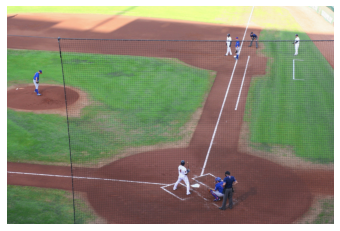

In [25]:
filename = "gs://asl-public/data/image_caption/redhawks_game.jpg"

img, result, attention_plot = predict_caption(filename)

for i in range(5):
    image, caption, attention_plot = predict_caption(filename)
    print(" ".join(caption[:-1]))
img = tf.image.decode_jpeg(tf.io.read_file(filename), channels=IMG_CHANNELS)
plt.imshow(img)
plt.axis("off");

The model has managed to capture the key aspects of the image: people, field, and baseball, although it is somewhat confused by the white line in the center and thinks it might be a tennis court, or street that the game is being played on.

## Summary
We learned how to build an image captioning model by creating an image encoder and a text decoder.

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.